In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i : np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i : np.log(i) if i > 0 else 0)


C:\Users\SJang\AppData\Local\Temp\ipykernel_12052\64561736.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# 3. Feature engineering
---
* 본격적인 feature engineering 을 시작해보겠습니다.
* 가장 먼저, dataset 에 존재하는 null data를 채우려고 합니다.
* 아무 숫자로 채울 수는 없고, null data 를 포함하는 feature 의 statistics 를 참고하거나, 다른 아이디어를 짜내어 채울 수 있습니다.
* null data 를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야할 부분입니다.
* Feature engineering 은 실제 모델의 학습에 쓰려고 하는 것이므로, train 뿐만아닐라 test 도 똑같이 적용해주어야 합니다. 잊지맙시다.

# 3.1 Fill Null
## 3.1.1 Fill Null in Age using title
---
* Age 에는 null data가 177개나 있습니다. 이를 채울 수 있는 여러 아이디어가 있을 것인데, 여기서 우리는 title + statistics 를 사용해 보겠습니다.
* 영어에서는 Miss, Mrr, Mrs 같은 title이 존재합니다. 각 탑승객의 이름에는 꼭 이런 title 이 들어가게 되는데 이를 사용해보겠습니다.
* pandas series 에는 data 를 string 으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있습니다. 이를 사용하여 title 을 쉽게 추출할 수 있습니다. title을 Initial column에 저장하겠습니다
* [정규표현식_Regular Expressions](https://nachwon.github.io/regular-expressions/)

In [2]:
# Lets extract the Salutations

df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

In [3]:
df_train.Initial

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Initial, Length: 891, dtype: object

pandas 의 crosstab 을 이용하여 우리가 추출한 Initial 과 Sex 간의 count 를 살펴봅시다.

In [4]:
# Checking the Initials with the Sex
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


위 table 을 참고하여, 남자, 여자가 쓰는 initial 을 구분해 보겠습니다. replace 메소드를 사용하면, 특정 데이터 값을 원하는 값으로 치환해줍니다.

In [5]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'], inplace=True)
df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [6]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


여성과 관계있는 Miss, Mrs 가 생존률이 높은 것을 볼 수 있습니다.

<Axes: xlabel='Initial'>

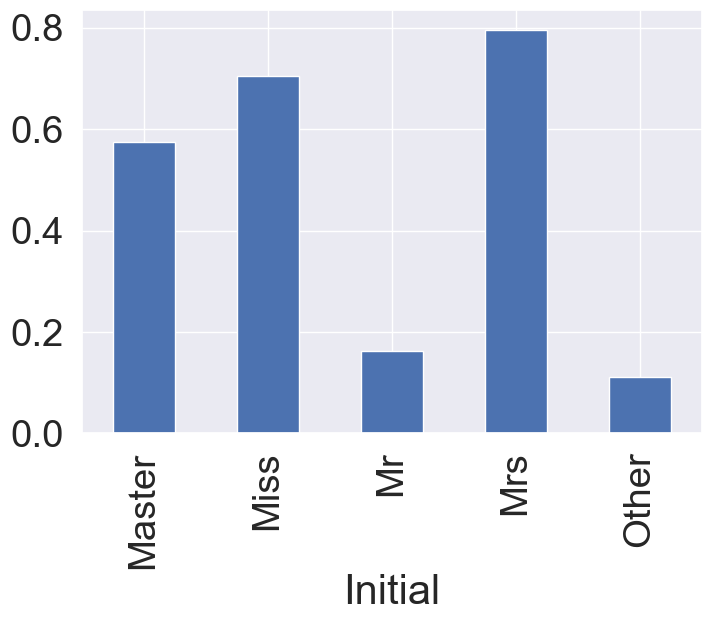

In [7]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

* 이제 본격적으로 Null 을 채울 것입니다. null data 를 채우는 방법은 정말 많이 존재합니다. statistics 를 활용하는 방법도 있고, null data 가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 여기서는 statistics 를 활용하는 방법을 사용할 것입니다.
* 여기서 statistics 는 train data 의 것을 의미합니다. 우리는 언제나 test 를 unseen 으로 둔 상태로 놔둬야 하며, train 에서 얻은 statistics 를 기반으로 test 의 null data 를 채워줘야 합니다.

In [8]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


* Age의 평균을 이용해 Null value 를 채우도록 하겠습니다.
pandas dataframe 을 다룰 때에는 boolean array를 이용해 indexing 하는 방법이 참으로 편리합니다.
* 아래 코드 첫줄을 해석하자면, isnull() 이면서 Initial 이 Mr 인 조건을 만족하는 row(탑승객) 의 'Age' 의 값을 33으로 치환한다 입니다.
* __loc + boolean + column__ 을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해집시다.

In [9]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'), 'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial =='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial =='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial == 'Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial == 'Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial =='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial =='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial =='Other'),'Age'] = 46

* 여기선 간단하게 Null을 채웠지만, 좀 더 다양한 방법을 쓴 예시들이 다른 커널에 존재합니다
* https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling 보시면서 공부해보세요!
* 이 외에도 다른 캐글러들의 커널을 보며 여러 참신한 아이디어를 살펴보세요!

## 3.1.2 Fill Null in Embarked

In [10]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), 'Null values')

Embarked has  2 Null values


* Embarked 는 Null value 가 2개이고, S 에서 가장 많은 탑승객이 있었으므로, 간단하게 Null 을 S로 채우겠습니다.
* dataframe 의 fillna method 를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True 로 하면 df_train 에 fillna 를 실제로 적용하게 됩니다

In [11]:
df_train['Embarked'].fillna('S', inplace=True)

# 3.2 Change Age(continuous to categorical)
---
* Age 는 현재 continuous feature 입니다. 이대로 써도 모델을 세울 수 있지만, Age 를 몇개의 group 으로 나누어 category 화 시켜줄 수 도 있습니다. continuous 를 categorical 로 바꾸면 자칫 information loss 가 생길 수도 있습니다만, 본 튜토리얼에서는 다양한 방법을 소개하는 것이 목적이므로 진행하도록 하겠습니다.
* 방법은 여러가지가 있습니다. dataframe 의 indexing 방법인 loc 를 사용하여 직접해줄 수 있고, 아니면 apply 를 사용해 함수를 넣어줄 수 있습니다.
* 첫번째로 loc 를 사용한 방법입니다. loc 는 자주쓰게 되므로 그 사용법을 숙지하시면 좋습니다.
* 나이는 10살 간격으로 나누겠습니다.

In [12]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age']<20), 'Age_cat'] = 1
df_train.loc[(20<=df_train['Age'])&(df_train['Age']<30),'Age_cat'] = 2
df_train.loc[(30<=df_train['Age'])&(df_train['Age']<40),'Age_cat'] =3
df_train.loc[(40<=df_train['Age'])&(df_train['Age']<50),'Age_cat'] =4
df_train.loc[(50<=df_train['Age'])&(df_train['Age']<60),'Age_cat'] =5
df_train.loc[(60<=df_train['Age'])&(df_train['Age']<70),'Age_cat'] =6
df_train.loc[70<=df_train['Age'],'Age_cat'] = 7


df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age']<20), 'Age_cat'] = 1
df_test.loc[(20<=df_test['Age'])&(df_test['Age']<30),'Age_cat'] = 2
df_test.loc[(30<=df_test['Age'])&(df_test['Age']<40),'Age_cat'] =3
df_test.loc[(40<=df_test['Age'])&(df_test['Age']<50),'Age_cat'] =4
df_test.loc[(50<=df_test['Age'])&(df_test['Age']<60),'Age_cat'] =5
df_test.loc[(60<=df_test['Age'])&(df_test['Age']<70),'Age_cat'] =6
df_test.loc[70<=df_test['Age'],'Age_cat'] = 7

두번째로 간단한 함수를 만들어 apply 메소드에 넣어주는 방법입니다.
훨씬 수월합니다.

In [13]:
def category_age(x):
    if x < 10:
        return 0
    elif x<20:
        return 1
    elif x<30:
        return 2
    elif x<40:
        return 3
    elif x<50:
        return 4
    elif x<60:
        return 5
    elif x<70:
        return 6
    else:
        return 7
    
df_train['Age_cat2'] = df_train['Age'].apply(category_age)

* 두가지 방법이 잘 적용됬다면, 둘다 같은 결과를 내야합니다.
* 이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용합시다. all() 메소드는 모든 값이 True 면 True, 하나라도 False 가 있으면 False 를 줍니다.

In [14]:
print('1번 방법, 2번 방법 둘 다 같은 결과를 내면 True 줘야 함 ->', (df_train['Age_cat']==df_train['Age_cat2']).all())

1번 방법, 2번 방법 둘 다 같은 결과를 내면 True 줘야 함 -> True


* 보시다시피 True 입니다. 둘 중 편한 걸 선택하시면 됩니다.
* 이제 중복되는 Age_cat 컬럼과 원래 컬럼 Age 를 제거하겠습니다.

In [15]:
df_train.drop(labels=['Age', 'Age_cat2'], axis=1, inplace=True)
df_test.drop(labels=['Age'], axis=1, inplace=True)

# 3.3 Change Initial, Embarked and Sex (string to numerical)
---
* 현재 Initial 은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야 합니다.
* map method 를 가지고 간단히 할 수 있습니다.
* 사전 순서대로 정리하여 mapping 하겠습니다

In [16]:
df_train['Initial'] = df_train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

* Embarked 도 C, Q, S로 이루어져 있습니다. map 을 이용해 바꿔봅시다.
* 그러기 앞서서, 특정 column 에 어떤 값들이 있는 지 확인해보는 방법을 잠깐 살펴보겠습니다. 간단히 unique() 메소드를 쓰거나, value_counts() 를 써서 count 까지 보는 방법이 있습니다.

In [17]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [18]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

위 두 방법을 사용해 Embarked가 S, C, Q 세가지로 이루어진 것을 볼 수 있습니다. 이제 map을 사용해봅시다

In [19]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

한번 Null 이 사라졌는지 확인해봅시다. Embarked Column만 가져온 것은 하나의 pandas의 Series 객체므로, isnull() 메소드를 사용해 Series의 값들이 null 인지 아닌지에 대한 boolean 값을 얻을 수 있습니다. 그리고 이것에 any() 를 사용하여, True 가 단하나라도 있을 시(Null이 한개라도 있을 시) True 를 반환해주게 됩니다. 우리는 Null 을 S로 다 바꿔주었으므로 False 를 얻게 됩니다

In [20]:
df_train['Embarked'].isnull().any()

False

Sex 도 Female, male 로 이루어져 있습니다. map 을 이용해 바꿔봅시다.

In [21]:
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})

* 여지껏 고생하셨습니다. 이제 각 feature 간의 상관관계를 한번 보려고 합니다. 두 변수간의 Pearson correlation 을 구하면 (-1, 1) 사이의 값을 얻을 수 있습니다. -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미합니다. 구하는 수식은 아래와 같습니다.
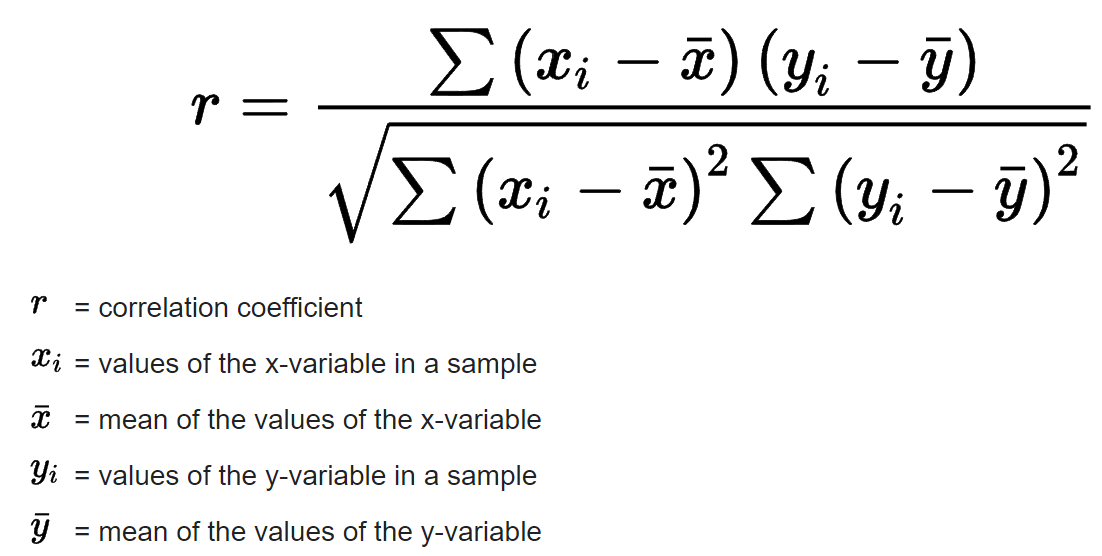
* 우리는 여러 feature 를 가지고 있으니 이를 하나의 maxtrix 형태로 보면 편할 텐데, 이를 heatmap plot 이라고 하며, dataframe 의 corr() 메소드와 seaborn 을 가지고 편하게 그릴 수 있습니다.

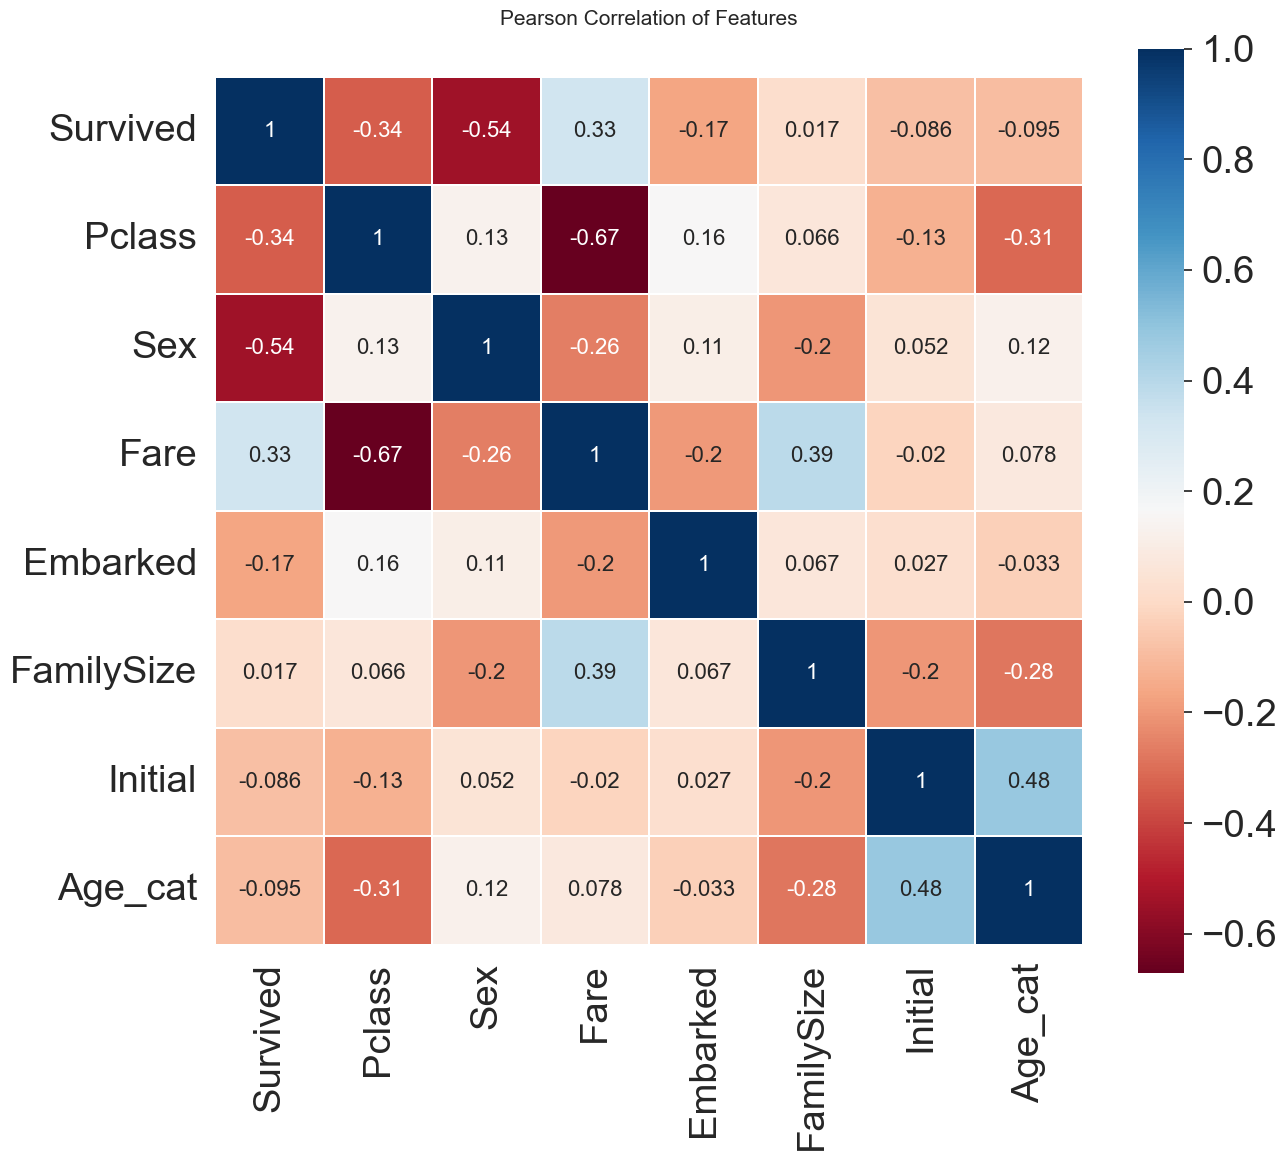

In [22]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked',
                        'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True,
           annot_kws={'size':16})
del heatmap_data

* 우리가 EDA에서 살펴봤듯이, Sex 와 Pclass 가 Survived 에 상관관계가 어느 정도 있음을 볼 수 있습니다.
* 생각보다 fare 와 Embarked 도 상관관계가 있음을 볼 수 있습니다.
* 또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것입니다.
* 이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature 가 없다는 것을 의미합니다. 1 또는 -1 의 상관관계를 가진 feature A, B 가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 거니까요.
* 이제 실제로 모델을 학습시키기 앞서서 data preprocessing (전처리)을 진행해보겠습니다. 거의 다 와갑니다 힙냅시다!

# 3.4 One-hot encoding on Initial and Embarked
---
* 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있습니다.
* 수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 로 매핑해주는 것을 말합니다.
* One-hot encoding 은 위 카테고리를 아래와 같이 (0, 1) 로 이루어진 5차원의 벡터로 나타내는 것을 말합니다.
* 위와 같은 작업을 직접 코딩할 수도 있지만, pandas 의 get_dummies 를 사용하여 쉽게 해결 할 수 있습니다.
* 총 5개의 카테고리니, one-hot encoding 을 하고 나면 새로운 5개의 column 이 생겨납니다.
* Initial 을 prefix로 두어서 구분이 쉽게 만들어 줍니다.

In [23]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


* 보시다시피 오른쪽에 우리가 만들려고 했던 one-hot encoded columns 가 생성된 것이 보입니다
* Embarked 에도 적용하겠습니다. Initial 때와 마찬가지로 one-hot encoding 을 사용해 표현하겠습니다.

In [24]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,0,0,1,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,2,3,0,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,1,2,0,1,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,3,0,0,0,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,1,3,0,0,1,0,0,0,0,1


* 아주 쉽게 one-hot encoding 을 적용했습니다.
* sklearn 로 Labelencoder + OneHotencoder 이용해도 one-hot encoding 이 가능합니다.
* 다른 튜토리얼에서 한번 써보겠습니다. 여기서는 get_dummies 로 충분히 가능하기 때문에 get_dummies 만으로 끝내겠습니다.
* 가끔 category 가 100개가 넘어가는 경우가 있습니다. 이때 one-hot encoding을 사용하면 column이 100개가 생겨, 학습시 매우 버거울 경우가 있습니다. 이런 경우는 다른 방법을 사용하기도 하는데, 이는 다음에 한번 다뤄보겠습니다.

# 3.5 Drop columns
---
고생하셨습니다. 이제 책상을 치울 때 입니다. 필요한 columns 만 남기고 다 지웁시다.

In [25]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [26]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [27]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


보시다시피, train 의 Survived feature(target class)를 빼면 train, test 둘다 같은 columns 를 가진 걸 확인할 수 있습니다.

# 4. Building machine learning model and prediction using the trained model
---
이제 준비가 다 되었으니 sklearn 을 사용해 본격적으로 머신러닝 모델을 만들어 봅시다.

In [28]:
# importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier

# 모델 평가를 위해 사용
from sklearn import metrics

# training set 을 쉽게 나눠주는 함수
from sklearn.model_selection import train_test_split

* Sklearn 은 머신러닝의 처음부터 끝까지가 다 있습니다. feature engineering, preprocessing, 지도 학습 알고리즘, 비지도 학습 알고리즘, 모델 평가, 파이프라인 등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되어 있습니다. 데이터 분석 + 머신러닝을 하고싶다면, 이 라이브러리는 반드시 숙지해야합니다.
* 파이썬 라이브러리를 활용한 머신러닝(Introduction to machine larning with Python)책을 사서 공부하시길 매우 추천해드립니다.
* 지금 타이타닉 문제는 target class(survived)가 있으며, target class 는 0, 1로 이루어져 있으므로(binary) binary classfication 문제입니다.
* 우리가 지금 가지고 있는 train set 의 survived를 제외한 input 을 가지고 모델을 최적화시켜서 각 샘플(탑승객)의 생존유무를 판단하는 모델을 만들어 냅니다.
* 그 후 모델이 학습하지 않았던 test set 을 input 으로 주어서 test set 의 각 샘플(탑승객)의 생존 유무를 예측해봅니다.

# 4.1 Preparation - Split dataset into train, valid, test set
---
가장 먼저, 학습에 쓰일 데이터와, target label(Survived)를 분리합니다. drop 을 사용해 간단히 할 수 있습니다.

In [29]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

* 보통 train, test 만 언급되지만, 실제 좋은 모델을 만들기 위해서 우리는 valid set을 따로 만들어 모델 평가를 해봅니다.
* 마치 축구대표팀이 팀훈련(train)을 하고 바로 월드컵(test)로 나가는 것이 아니라, 팀훈련(train)을 한 다음 평가전(valid)를 거쳐 팀의 훈련 정도(학습정도)를 확인하고 월드컵(test)에 나가는 것과 비슷합니다.
* train_test_split 을 사용하여 쉽게 train 셋을 분리할 수 있습니다.

In [30]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

* sklearn 에서는 여러 머신러닝 알고리즘을 지원해줍니다. 열거하기엔 너무 많으므로, 직접 documentation에 들어가 보시길 추천합니다. http://scikit-learn.org/stable/supervised_learning.html#supervised-learning 여기에 들어가시면 지원되는 알고리즘 수에 놀라실 겁니다.
* 본 튜토리얼에서는 랜덤포레스트 모델을 사용하도록 하겠습니다.
* 랜덤포레스트는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델입니다. 더 구체적인 모델 설명은 여러 블로그들 참고하시면 될 것이고, 저도 한번 추후 다뤄보겠습니다.
* 각 머신러닝 알고리즘에는 여러 파라미터들이 있습니다. 랜덤포레스트분류기도 n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등 여러 파라미터들이 존재합니다. 이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라집니다.
* 파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해 등이 필요합니다. 결국 많이 써봐야 모델도 잘 세울 수 있는 것이죠. 그래서 캐글을 추천합니다. 여러 데이터셋을 가지고 모델을 이리저리 써봐야 튜닝하는 감이 생길테니까요!
* 일단 지금은 튜토리얼이니 파라미터 튜닝은 잠시 제쳐두기로 하고, 기본 default 세팅으로 진행하겠습니다.
* 모델 객체를 만들고, fit 메소드로 학습시킵니다.
* 그런 후 valid set input 을 넣어주어 예측값(X_vld sample(탑승객)의 생존여부)를 얻습니다.

# 4.2 Model generation and prediction

In [31]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

* 단 세줄만으로 여러분은 모델을 세우고, 예측까지 해봤습니다.
* 자, 이제 모델의 성능을 한번 살펴보겠습니다.

In [32]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100*metrics.accuracy_score(prediction, y_vld)))

총 268명 중 81.34% 정확도로 생존을 맞춤


아무런 파라미터 튜닝도 하지 않았는데 82% 의 정확도가 나왔습니다. 고생하셨습니다!

# 4.3 Feature importance
---
* 학습된 모델은 feature importance 를 가지게 되는데, 우리는 이것을 확인하여 지금 만든 모델이 어떤 feature 에 영향을 많이 받았는 지 확인할 수 있습니다.
* 쉽게 말해, 10 = 4x1 + 2x2 + 1*x3 을 생각하면, 우리는 x1이 결과값(10)에 큰 영향을 준다고 생각 할 수 있습니다. feature importance 는 4, 2, 1 을 이야기하며, x1이 가장 큰 값(4)를 가지므로, 이 모델에 가장 큰 영향을 미친다고 말할 수 있습니다.
* 학습된 모델은 기본적으로 featureimportances 를 가지고 있어서 쉽게 그 수치를 얻을 수 있습니다.
* [pandas series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) 를 이용하면 쉽게 sorting 을 하여 그래프를 그릴 수 있습니다

In [33]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

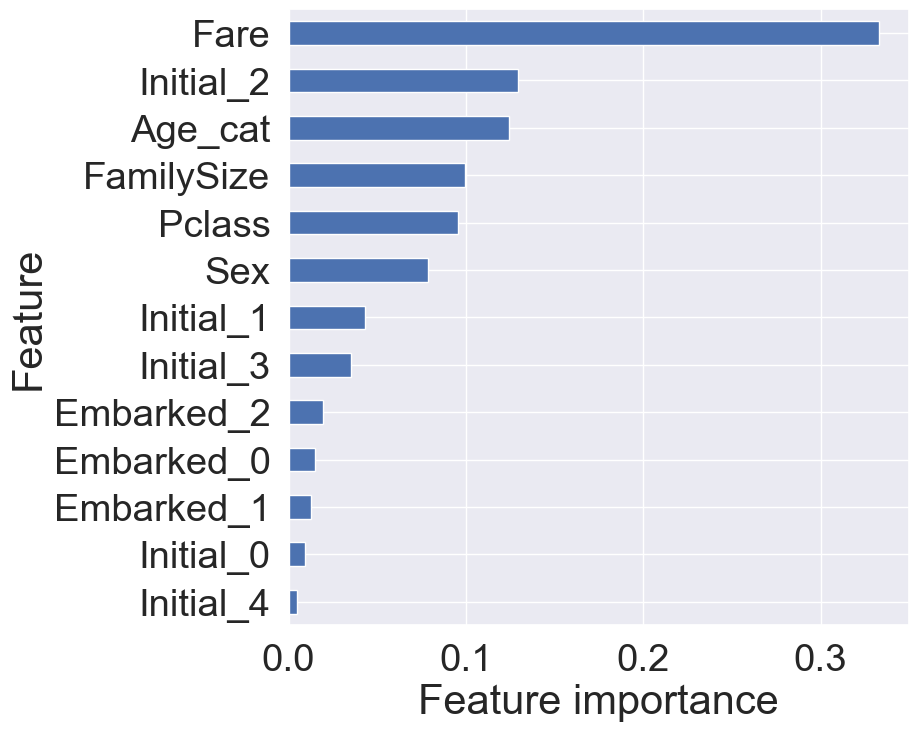

In [40]:
plt.figure(figsize=(8,8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

* 우리가 얻은 모델에서는 Fare 가 가장 큰 영향력을 가지며, 그 뒤로 Initial_2, Age_cat, Pclass가 차례로 중요도를 가집니다
* 사실 feature importance 는 지금 모델에서의 importance 를 나타냅니다. 만약 다른 모델을 사용하게 된다면 feature importance 가 다르게 나올 수 있습니다.
* 이 feature importance 를 보고 실제로 Fare 가 중요한 feature 일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴보긴 해야합니다.
* featuure importance 를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection 을 할 수도 있고, 좀 더 빠른 모델을 위해 feature 제거를 할 수 있습니다.

# 4.4 Prediction on Test set
---
* 이제 모델이 학습하지 않았던(보지 않았던) 테스트셋을 모델에 주어서, 생존여부를 예측해보겠습니다.
* 이 결과는 실제로 submission(제출용) 이므로 결과는 leaderboard 에서 확인할 수 있습니다.
* 캐글에서 준 파일, gender_submission.csv 파일을 읽어서 제출 준비를 하겠습니다.

In [41]:
submission = pd.read_csv('./data/gender_submission.csv')
submission.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


이제 testset 에 대하여 예측을 하고, 결과를 csv 파일로 저장해보겠습니다.

In [42]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [43]:
submission.to_csv('./my_submission.csv', index=False)

이제 캐글에 제출해보도록 합시다.

# 5. Conclusion
---
* 정말 수고하셨습니다. 여러분은 titanic dataset 을 가지고 data science 를 경험해보셨습니다.
* 이걸로 끝이 아닙니다. 앞으로 배울 것이 너무나 무궁무진합니다.
* 좀 더 참신한 feature engineering, 머신 러닝 모델 hyperparameter tunning, ensembling 등, 무궁무진합니다..
* 꾸준히 커널공부를 하시면 실력이 꾸준히 늘겁니다.
* 포기하지 마시고 재밌게 하시면 됩니다
* 본 튜토리얼을 따라해주셔서 감사하며, 제 유투브 채널에 강의도 올려놨으니 한번 보시면 됩니다!
* 본 튜토리얼을 따라하시다가, 혹시 문제가 있거나, 궁금한 사항이 있으면 언제든 말씀해주세요! 저도 더 성장하길 원합니다!